# Project-4: Создание основы рекомендательной системы для онлайн школы

Онлайн школе MasterMind требуется решение бизнес-проблемы - увеличение среднего чека. Решено предлагать слушателям курсы, которые могут быть им интересны, для чего требуется создание рекомендательной системы - таблицы, в которой каждому курсу будут соответствовать по две рекомендации.

## ЦЕЛЬ
Подготовить основу рекомендательной системы.

## ЗАДАЧИ
1. Познакомиться с датасетом, подготовить и проанализировать данные с помощью SQL.
2. Обработать данные средствами Python.
3. Составить итоговую таблицу с рекомендациями, снабдив её необходимыми комментариями, и представить отчёт продакт-менеджеру.

Нам необходимо определить какие курсы мы будем предлагать нашим студентам. Можно взять выборку из всех курсов и предлагать рамдомно 2 курса. В этом случае выборка курсов самая большая, однако мы можем не попасть в область интересов студентов и не заинтересовать их вовсе.

Мы можем предлагать самые популярные курсы. Однако, это тоже не кажется правильным выбором, потому что школа MasterMind имеет разные курсы, на создание которых тратились ресурсы школы и необходимо повышать интерес студентов к ним.

Таким образом, наиболее правильным кажется предлагать студентам курсы, котрые чаще покупают вместе с конкретными курсами, потому что студенты могут покупать разные курсы из одной предметной области, либо выбранные курсы могут быть продолжением уже пройденных курсов.

In [1]:
# загружаем необходимые библиотеки для обработки данных
import pandas as pd
import psycopg2
import psycopg2.extras 

In [2]:
# создаем транзакцию

# определяем параметры соединения с бд
try:
    connection = psycopg2.connect(
        user = 'skillfactory',
        password = 'cCkxxLVrDE8EbvjueeMedPKt',
        host = '84.201.134.129',
        port = '5432',
        database = 'skillfactory'
    )

# создаем запрос для выгрузки данных по продажам курсов в разрезе 
# пользователей, которые купили более одного курса   
    query = """select user_id, course_id
                from
                (select c.user_id user_id, 
                        ci.resource_id course_id,
		                count(ci.resource_id) over(
			                partition by c.user_id) purchased_courses_cnt
	            from final.carts c
	            join final.cart_items ci on c.id = ci.cart_id
	            where ci.resource_type = 'Course'
		            and c.state = 'successful'
	            group by c.user_id, 
                    ci.resource_id, 
                    ci.resource_type, 
                    c.state) as purchased_courses_table
                where purchased_courses_cnt > 1"""
    
# создаем курсор для хранения результата запроса                
    cursor = connection.cursor()
    dict_cur = connection.cursor(cursor_factory=psycopg2.extras.DictCursor)
# передаем запрос в бд
    dict_cur.execute(query)
# передаем результат запроса в переменную data    
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
        
# создаем исключение, на случай возникновения ошибки   
except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)
# закрываем соединение с бд
finally:
    if connection:
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")

PostgreSQL connection is closed


In [3]:
# создаем датафрейм с результатом запроса
purchased_courses_df = pd.DataFrame(data)
# выводим информацию о созданном датафрейме и
# проверяем результат запроса на отсутствие пропуском
purchased_courses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34074 entries, 0 to 34073
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    34074 non-null  int64
 1   course_id  34074 non-null  int64
dtypes: int64(2)
memory usage: 532.5 KB


In [4]:
purchased_courses_df.head()

,user_id,course_id
0,51,516
1,51,1099
2,6117,356
3,6117,357
4,6117,1125


Итак, мы получили данные о пользователях и курсах, которые они покупали. На основе этих данных мы можем создать таблицу - основу рекомендательной системы, в которой каждому курсу будут подобраны 2 рекомендации. 

In [5]:
print('Количество уникальных пользователей, \
которые купили более 1 курса:', purchased_courses_df['user_id'].nunique())

Количество уникальных пользователей, которые купили более 1 курса: 12656


In [6]:
print('Количество уникальных курсов, которые были \
куплены пользователями более 1 раза:', purchased_courses_df['course_id'].nunique())

Количество уникальных курсов, которые были куплены пользователями более 1 раза: 126


На предудущем шаге исследования данных мы выяснили, что общее количество курсов составляет 127. Значит, информации об одном курсе нет в предыдущем запросе, потому что пользователи не покупали его вовсе или не покупали вместе с другими курсами.

ID номер этого курса необходим для добавления его в финальную таблицу.

Создадим запрос в БД для определения ID этого курса.

In [7]:
# создаем транзакцию

# определяем параметры соединения с бд
try:
    connection = psycopg2.connect(
        user = 'skillfactory',
        password = 'cCkxxLVrDE8EbvjueeMedPKt',
        host = '84.201.134.129',
        port = '5432',
        database = 'skillfactory'
    )
# создаем запрос к бд для выгрузки информации о курсе, 
# который пользователи не покупали  
    query = """select ci.resource_id never_bought_course
            from final.cart_items ci
            where ci.resource_type = 'Course' 
            group by ci.resource_id

            EXCEPT

            (select ci.resource_id course_id
            from final.carts c
            join final.cart_items ci on c.id = ci.cart_id
            where ci.resource_type = 'Course' 
                and c.state = 'successful'
            group by ci.resource_id)"""

# создаем курсор для хранения результата запроса                
    cursor = connection.cursor()
# передаем запрос бд
    cursor.execute(query)
# передаем результат запроса в переменную record
    record = cursor.fetchone()
    
# создаем исключение, на случай возникновения ошибки      
except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)
    
# закрываем соединение  
finally:
    if connection:
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")

PostgreSQL connection is closed


In [8]:
# передаем ID курса, который не покупали в переменую missing_course
missing_course = record[0]
print('Id курса, который не покупали вместе с другими курсами:', missing_course)

Id курса, который не покупали вместе с другими курсами: 772


Создадим визуализацию распределения продаж курсов, чтобы понять равномерно ли пользователи покупают курсы или же среди курсов есть те, которые покупают чаще других.

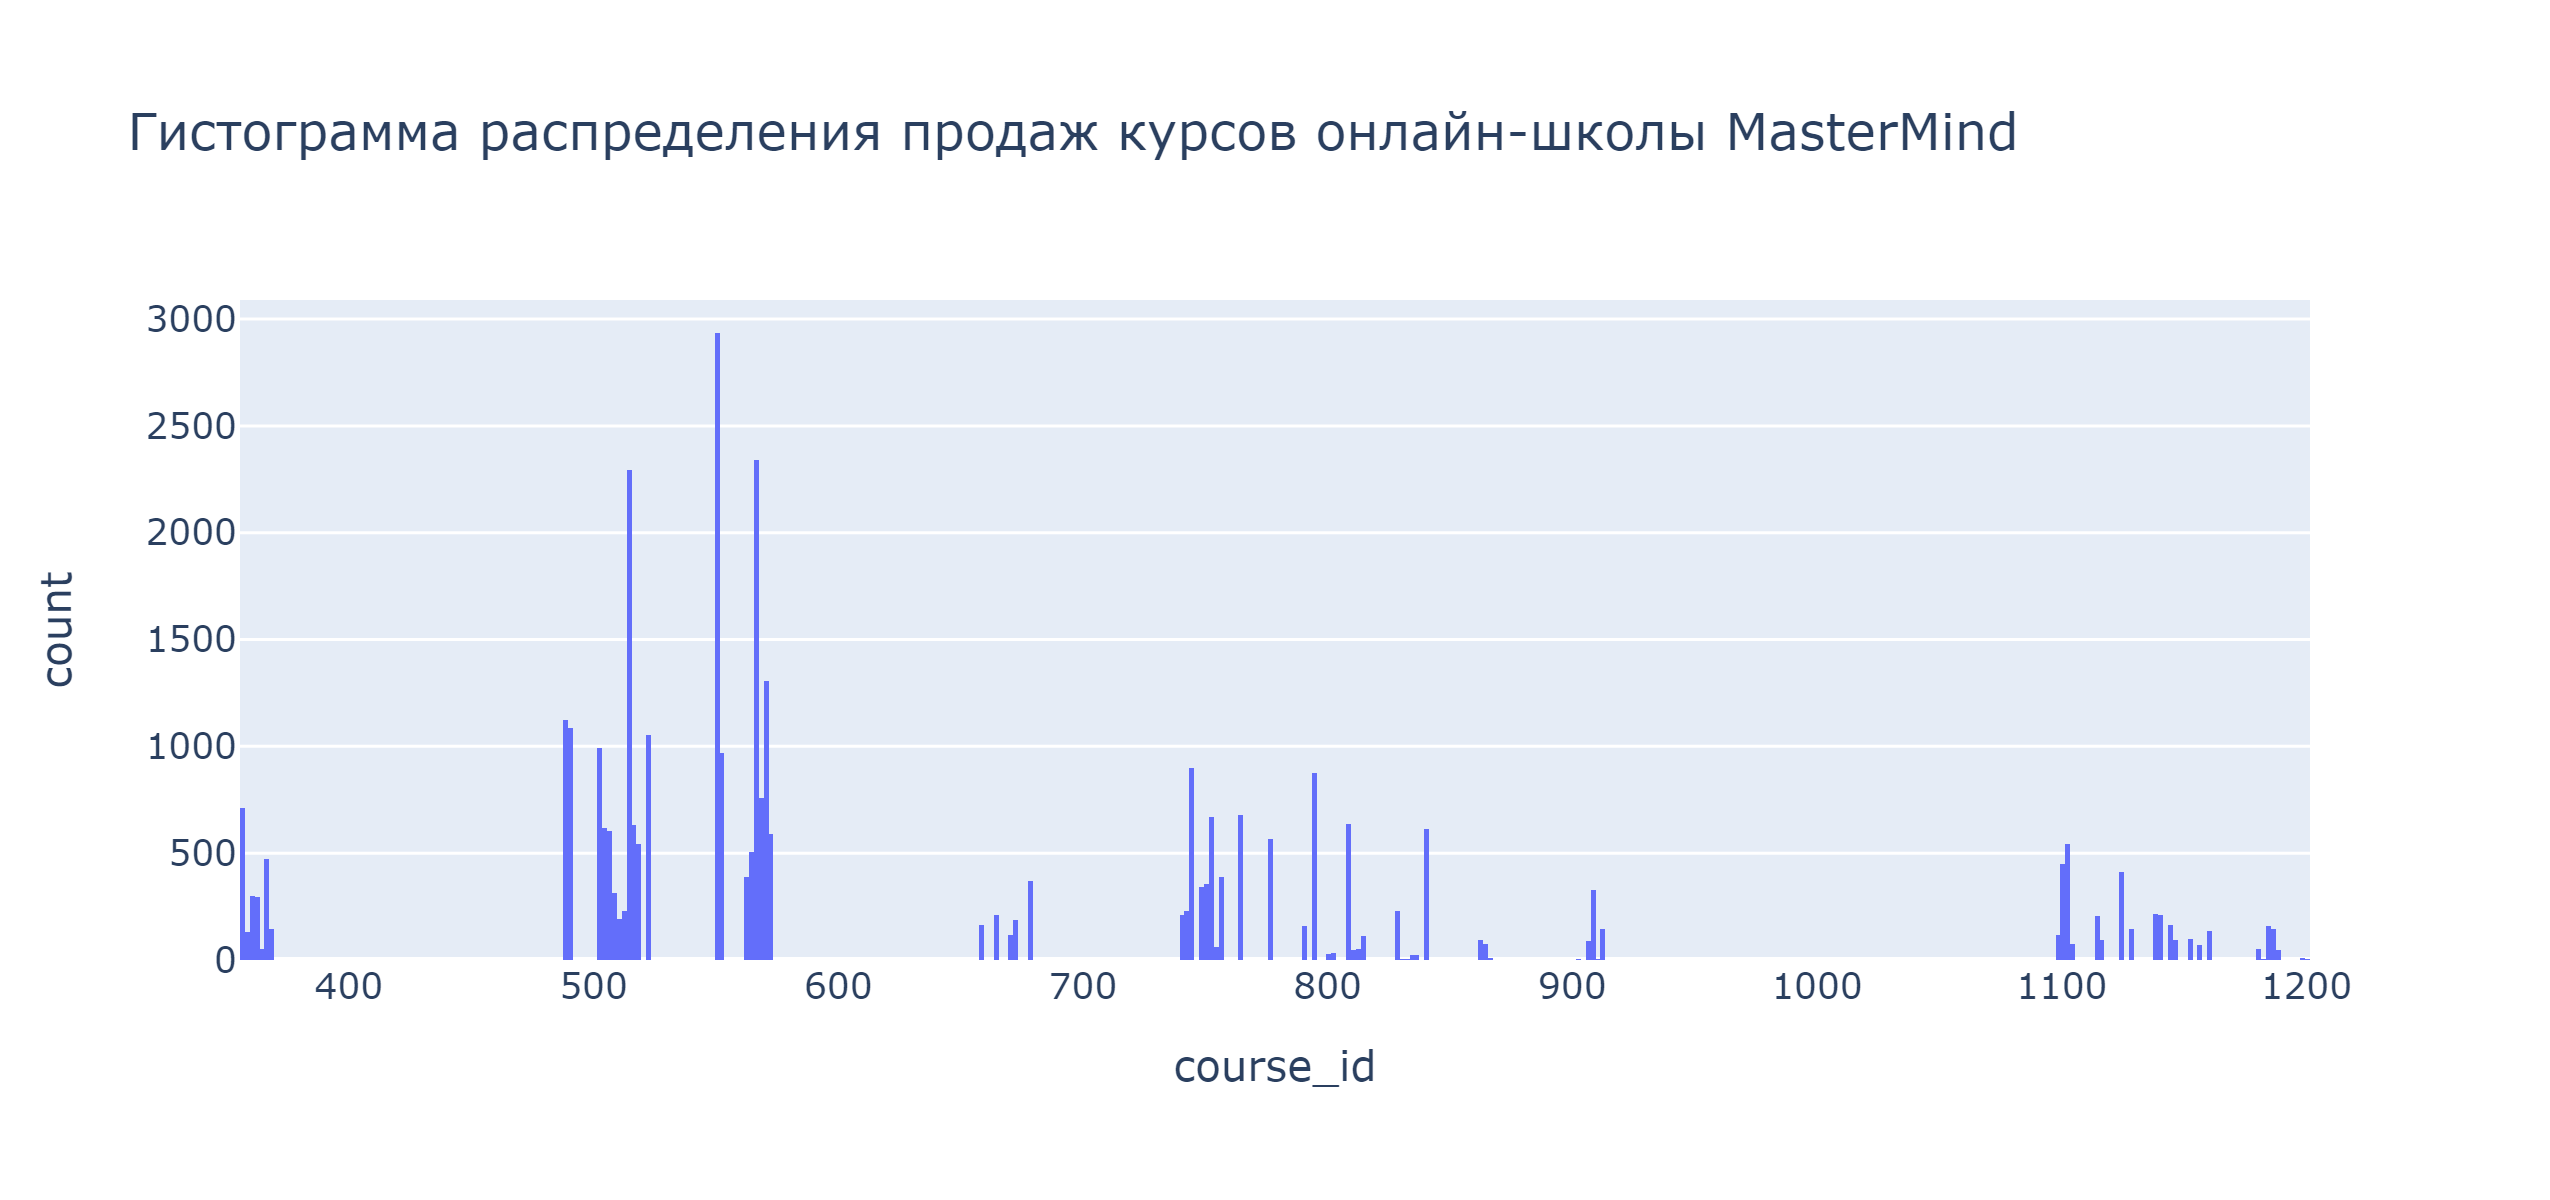

In [9]:
# загружаем необходимые библиотеки для создания визуализаций
import plotly.express as px
from IPython.display import Image

# создаем гистограмму, отображающую частоту продаж курсов
fig = px.histogram(purchased_courses_df, 
                   x='course_id', 
                   nbins=500, 
                   title='Гистограмма распределения продаж курсов онлайн-школы MasterMind')

# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

Визуально распределение продаж курсов далеко от нормального. 

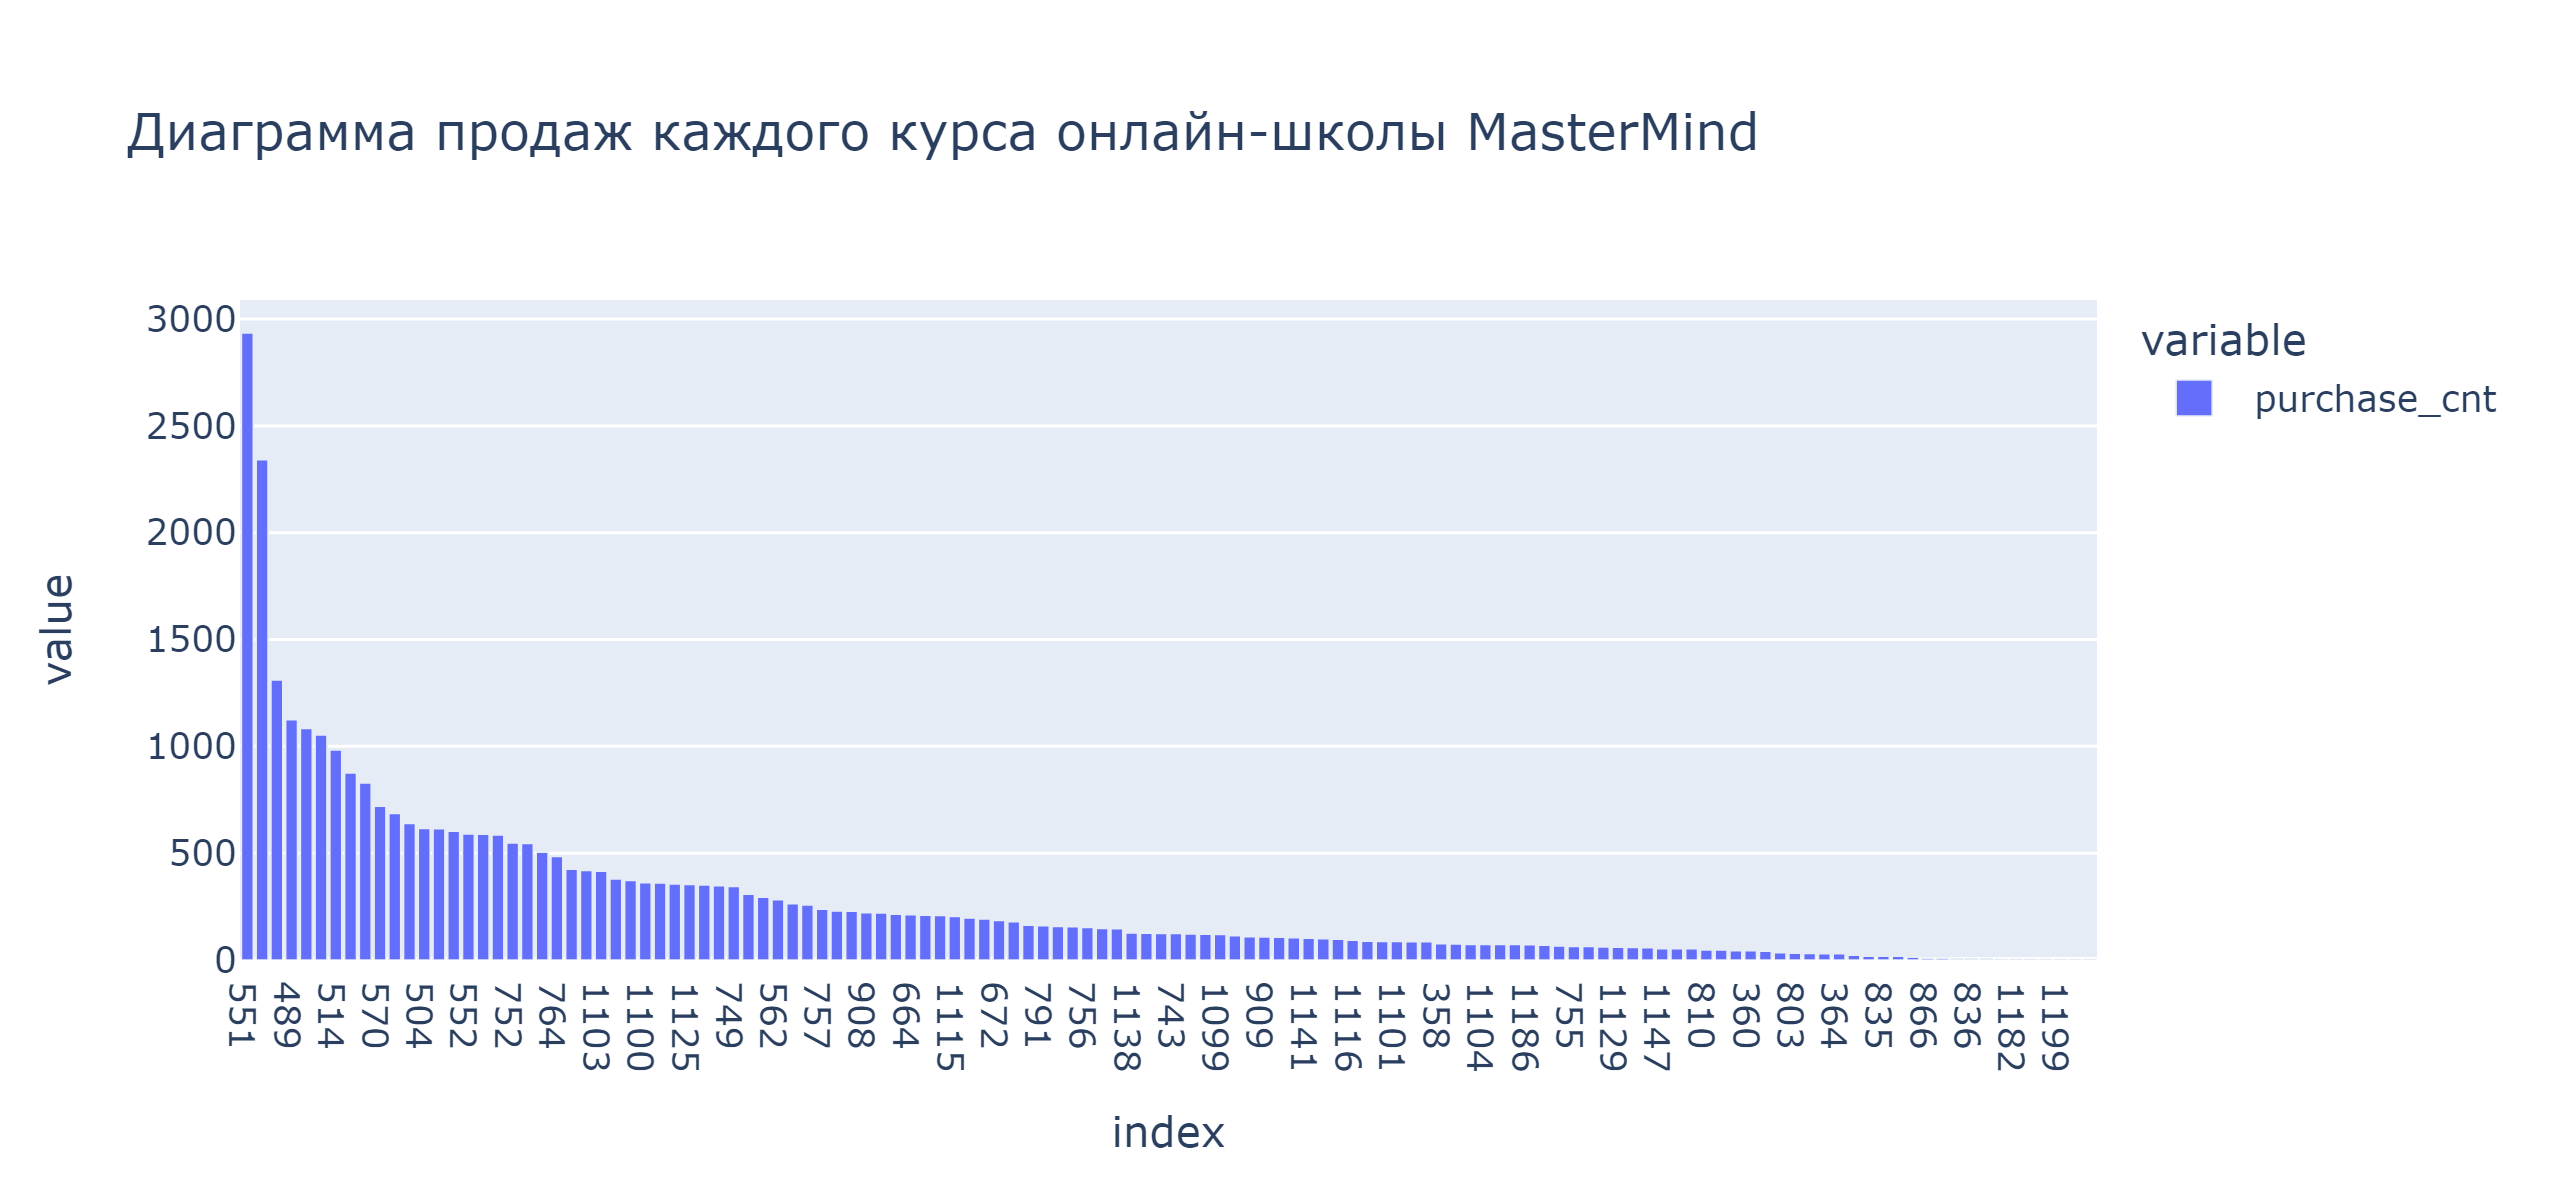

In [10]:
# импортируем defaultdict из библиотеки collections
from collections import defaultdict

# выгружаем счетчик Counter из библиотеки collections для подсчета продаж курсов
from collections import Counter
 
# создаем список, в котором вхождения курсов будут
# столько раз, сколько было продано этих курсов
purchased_courses_lst = list(purchased_courses_df['course_id'])
# создаем словарь с помощбю Counter, в котором будет подсчет продаж каждого курса
# с помощью метода most_common расположим курсы в порядке убывания количества продаж
purchased_courses_cnt = Counter(purchased_courses_lst).most_common()

# создаем defaultdict с данными о курсах и числом их продаж
purchased_courses_dict = defaultdict()
for course_id, cnt in purchased_courses_cnt:
    purchased_courses_dict[course_id] = cnt

# создаем датафрейм на основе полученного defaultdict
bar_df = pd.DataFrame(
    data=purchased_courses_dict.values(),
    columns=['purchase_cnt'],
    index=map(str, purchased_courses_dict.keys())
)

# создаем столбчатую диаграмму, чтобы наглядно отобразить как продажи одних 
# курсов отличаются от продаж других 
fig = px.bar(bar_df, title='Диаграмма продаж каждого курса онлайн-школы MasterMind')
# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

In [11]:
bar_df['purchase_cnt'].describe()

count     126.000000
mean      270.428571
std       404.128483
min         2.000000
25%        58.500000
50%       124.000000
75%       350.000000
max      2935.000000
Name: purchase_cnt, dtype: float64

Визуаицация и базовые статистики данных по продажамкурсов свидельствуют о сильном смещении продаж в сторону определенных курсов. Средний показатель продаж - 270 продаж - значительно отличается в большую сторону от медианного показателя - 124 продажи.

В выборке присутствуют выбросы - курсы, которые продаются в разы чаще других курсов:  курс 551 продан 2 935 раза, 566 - 2 342 раза.

Исходя из распределения продаж курсов, мы можем ожидать что есть такие курсы, которые пользователи не часто покупали вместе с другими курсами. Т.е. мы не сможем дать рекомендации к этим курсам.

Для таких курсов, мы дадим рекомендации из числа самых популярных курсов. Да, таким образом мы можем не попать в предметную область интересующую конкретного пользователя, но это может способствовать тому чтобы пользователь сам проверил курсы на платформе школы.

Поскольку на 10 самых популярных курсов приходится примерно 46% всех купленных курсов. т.е. пользователи и так осведомлены об этих курсах, возьмем выборку больше - 25% курсов. Это те курсы которые были куплены 350 раз и более. Это довольно популярные курсы с одной стороны и с другой - более разнообразная выборка.

In [12]:
# выгружаем библиотеки itertools и numpy для создания списков 
# курсов, купленных каждым пользователем, и комбинаций этих курсов 
import itertools
import numpy as np
from collections import Counter

# создаем датафрейм с пользователями и списками купленных ими курсов
courses_comb_df = purchased_courses_df.groupby(
    'user_id')['course_id'].apply(lambda x: list(np.unique(x))).reset_index()

# создаем пустой список для комбинаций курсов, купленных покупателями
courses_comb_list = []
# проходим по спискам курсов в созданном датафрейме и создаем комбиниции по 2 курса
for courses in courses_comb_df['course_id']:
    for combs in itertools.combinations(courses, 2):
        courses_comb_list.append(combs)

# создаем словарь с комбинациями курсов по 2 штуки и количеством продаж данных комбинаций курсов
# с помощью метода most_common сортируем комбинации курсов в порядке убывания продаж        
courses_comb_dict = dict(Counter(courses_comb_list).most_common())

In [13]:
# создаем функцию для выведения 2 рекомендаций выбранному курсу
def get_recommendation_lst(course_id):
    # создаем пустой список, в который будем класть рекомендации
    recommendations_list = []
    # проходим по ключам словаря courses_comb_dict
    for comb in courses_comb_dict.keys():
        # если выбранный курс равен первому курсу в комбинации курсов, 
        # кладем элемент словаря в созданный список 
        if comb[0] == course_id:
            recommendations_list.append(
                (comb, courses_comb_dict[comb])
            )
    # сортируем полученный список по убыванию количества 
    # продаж комбинаций курсов
    sorted_recommendations_list = sorted(recommendations_list, 
                                         key=lambda x: x[1], 
                                         reverse=True)
    # функция возвращает до 2х элементов полученного списка рекомендаций
    return sorted_recommendations_list[:2]
        
# проверка        
print(get_recommendation_lst(566))

[((566, 794), 290), ((566, 764), 92)]


In [14]:
# выводим список уникальных курсов из первоначальо полученного датафрейм
courses_list = list(map(int, purchased_courses_df['course_id'].unique()))
# добавляем в список курс, продаж которого не было
courses_list.append(missing_course)

In [15]:
 # создаем словарь для рекомендаций популярных курсов
popular_courses_recommendation_dict = dict()
# проходим по элементам словаря (курсам и числу их продаж)
for course, cnt in purchased_courses_dict.items():
    # если число продаж курса более 349, добавляем курс в словарь
    if cnt > 349:
        popular_courses_recommendation_dict[course] = cnt

# создаем список из курсов, число продаж которых превышает 349 раз
popular_courses_recommendation_list = list(popular_courses_recommendation_dict.keys())

In [16]:
print('Количество выбранных популярных курсов:', len(popular_courses_recommendation_list))

Количество выбранных популярных курсов: 32


Создадим 2 выборки популярных курсов, для того чтобы рекомендации 1 и 2 не повторялись.

In [17]:
# рамдомно выбираем 16 элементов из списка популярных курсов для создания
# списка первых рекомендаций (для курсов, которые не продавались вместе с другими курсами)
# выбираем параметр replace=False, чтобы увеличить количество предложенных популярных курсов 
popular_courses_1_recommendation = np.random.choice(popular_courses_recommendation_list, 
                                                    size=16, replace=False)
# для создания списка вторых рекомендаций убираем выбранные для 
# первого списка курсы из общего списка популярных курсов
popular_courses_2_recommendation = list(
    set(popular_courses_recommendation_list) - set(popular_courses_1_recommendation)
)

Необходимо также проверить комбинации кусров по количество продаж. 

Создадим рейтинг покупок пар курсов.

In [18]:
# создаем датафрейм с данными о комбинациях курсов и количеством их 
# продаж из словаря courses_comb_dict, где строками выступают ключи словаря
rating_df =pd.DataFrame.from_dict(courses_comb_dict, orient='index').reset_index()
# обозначаем названия столбцов
rating_df.columns = ['courses_comb', 'rating']
rating_df

,courses_comb,rating
0,"(551, 566)",797
1,"(515, 551)",417
2,"(489, 551)",311
3,"(523, 551)",304
4,"(566, 794)",290
...,...,...
3984,"(741, 791)",1
3985,"(361, 1128)",1
3986,"(743, 1156)",1
3987,"(864, 1129)",1


In [19]:
# создаем новый датафрейм группируя рейтинг и соответствующее кол-во продаж курсов
grouped_rating = rating_df.groupby('rating')['courses_comb'].count().reset_index()
# обозначаем названия столбцов 
grouped_rating.columns = ['rating', 'course_pair_cnt']
grouped_rating.head(15)

,rating,course_pair_cnt
0,1,1185
1,2,578
2,3,366
3,4,259
4,5,202
5,6,148
6,7,148
7,8,95
8,9,80
9,10,87


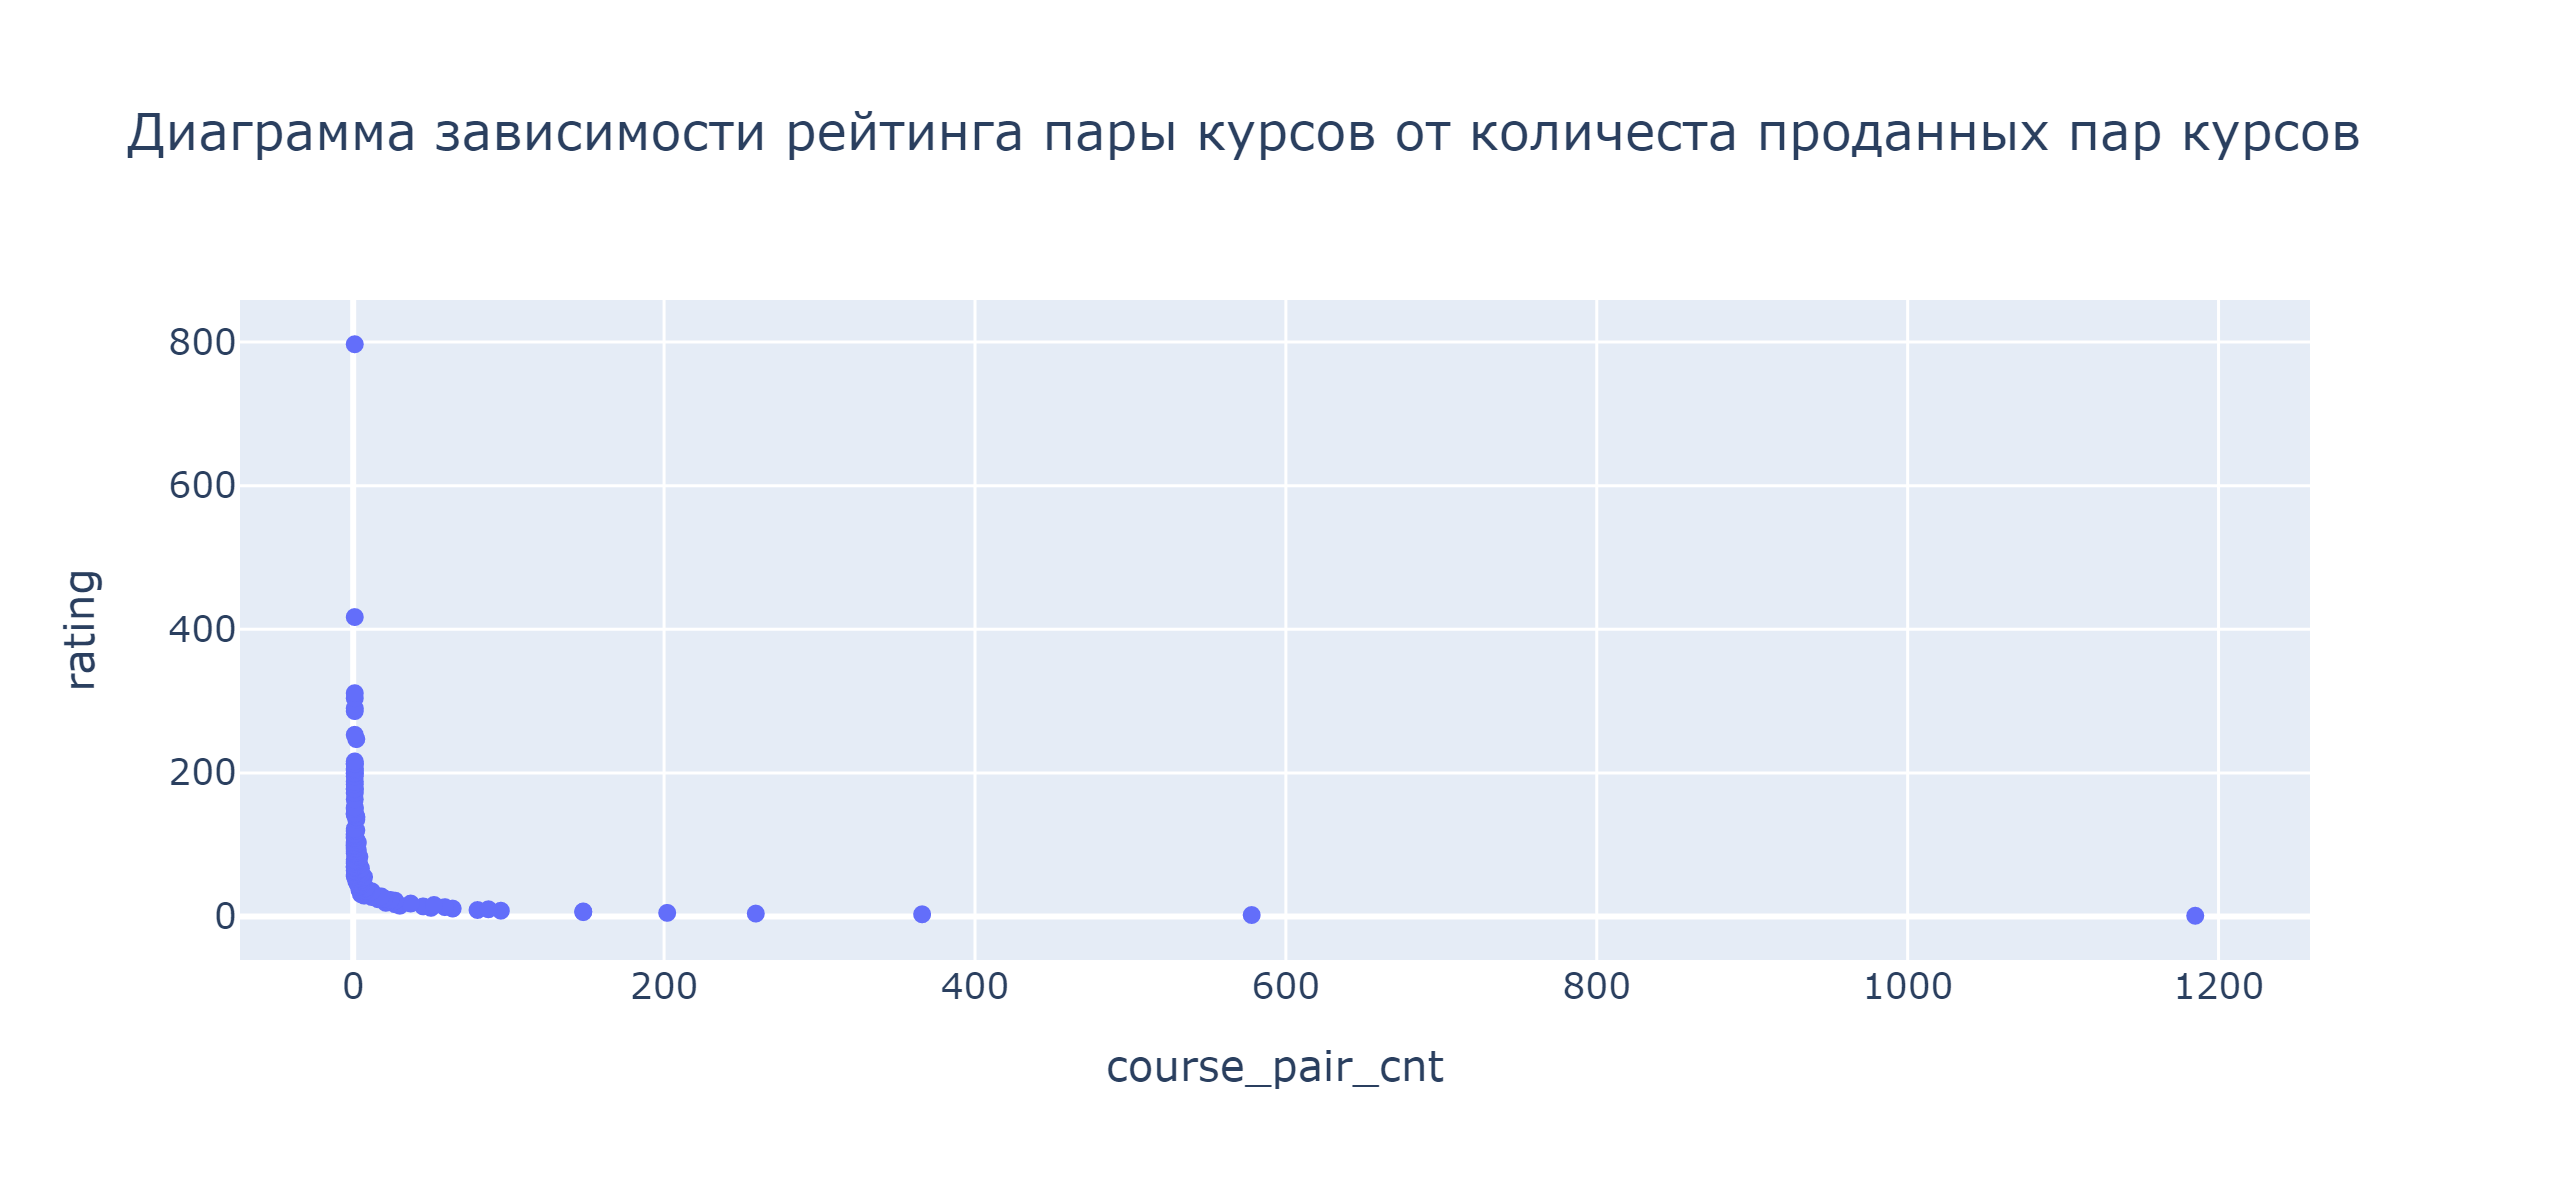

In [20]:
# создаем диаграмму рассеяния, чтобы показать зависимость 
# рейтинга пары курсов от количества продаж курсов
fig = px.scatter(grouped_rating,
                 x = 'course_pair_cnt',
                 y = 'rating',
                 title='Диаграмма зависимости рейтинга пары курсов от количеста проданных пар курсов')
# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

На графике видно, что больше всего пар курсов пользователи покупали по одному разу. Наибольшая плотность количества покупок пар курсов концентрируется от 1 до примерно 100 раз. Из таблицы рейтингов grouped_rating мы понимаем, что точное значение это - 95 пар курсов. Соответствено, рейтинг (количество продаж) равен 8.

Итак, предлагать пользователям пары курсов с меньшим рейтингом может быть не логично, потому что пользователи могут покупать эти пары по своим субъективным причинам. Т.е. предлогая эти пары мы можем не попасть в предметную область и преглагаем курсы с меньшим рейтингом.

Добавим условие, рейтинг более или равен 8, в цикл создания финальной таблицы рекомендаций. Вместо менеее популярных курсов будем предлагать ранее выбранные популярные курсы.

In [21]:
# создаем финальный датафрейм всех курсов и 2 рекоммендаций к каждому курсу 
recommendation_df = pd.DataFrame(
    columns=[
        'course_id', 
        'first_recommendation', 
        'second_recommendation']
)
# проходим по каждому курсу в списке всех курсов
for course in courses_list:
    # если функция get_recommendation выводит список из 2х рекомендаций и рейтинг рекомендаций больше 8,
    # добавляем курс, первую и вторую рекоммендации в финальный датафрейм
    if len(get_recommendation_lst(course)) == 2 and get_recommendation_lst(course)[0][1] >= 8 and get_recommendation_lst(course)[1][1] >= 8:
        recommendation_df.loc[course] = [course, 
                                    get_recommendation_lst(course)[0][0][1], 
                                    get_recommendation_lst(course)[1][0][1]]
    # если функция get_recommendation выводит список из 2х рекомендаций и рейтин второй рекомендации меньше 8,
    # добавляем курс, первую рекомендацию и вторую - случайно выбранную рекомендацию из списка популярных рекомендацй
    elif len(get_recommendation_lst(course)) == 2 and get_recommendation_lst(course)[0][1] >= 8 and get_recommendation_lst(course)[1][1] < 8:
        recommendation_df.loc[course] = [course, 
                                    get_recommendation_lst(course)[0][0][1], 
                                    np.random.choice(popular_courses_2_recommendation)]
    # если функция get_recommendation выводит список из 2х рекомендаций и рейтин обеих рекомендаций меньше 8,
    # добавляем курс, первую и вторую рекомендации - случайно выбраннуые рекомендацию из списков популярных рекомендацй
    elif len(get_recommendation_lst(course)) == 2 and get_recommendation_lst(course)[0][1] < 8 and get_recommendation_lst(course)[1][1] < 8:
        recommendation_df.loc[course] = [course, 
                                np.random.choice(popular_courses_1_recommendation), 
                                np.random.choice(popular_courses_2_recommendation)]
    # если функция get_recommendation выводит список из 1 рекомендации и рейтинг рекомендации больше 8,
    # формируем вторую рекомендацию из списка популярных курсов для второй рекоммендации 
    # и все полученные данные добавляем в финальный датафрейм
    elif len(get_recommendation_lst(course)) == 1 and get_recommendation_lst(course)[0][1] >= 8:
        recommendation_df.loc[course] = [course, 
                                    get_recommendation_lst(course)[0][0][1], 
                                    np.random.choice(popular_courses_2_recommendation)]
    # если нет рекомендаций из купленных другими пользователями пар курсов или выбранная рекомендация имеет низкий рейтинг,
    # формируем обе рекомендации из списков рекомендаций из популярных курсов
    else:
        recommendation_df.loc[course] = [course, 
                                np.random.choice(popular_courses_1_recommendation), 
                                np.random.choice(popular_courses_2_recommendation)]

# сортируем полученных датафрейм по ID курсов
recommendation_df = recommendation_df.sort_values(
    ['course_id']
).reset_index(drop=True)

recommendation_df.tail(15)

,course_id,first_recommendation,second_recommendation
112,1152,572,1103
113,1156,564,356
114,1160,809,750
115,1161,552,764
116,1181,1184,519
117,1182,1100,519
118,1184,514,502
119,1185,1188,502
120,1186,809,569
121,1187,490,750


In [22]:
# проверяем финальный датафрейм на наличие пропусков
recommendation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   course_id              127 non-null    int64
 1   first_recommendation   127 non-null    int64
 2   second_recommendation  127 non-null    int64
dtypes: int64(3)
memory usage: 3.1 KB


Получилась таблица с рекомендациями к каждому курсу из пар курсов купленных другими пользователями. При том, если курс не покупался вместе с другими курсами, в качестве рекомендации предлагаются курсы с высокими рейтингами. Если курс покупался совместно с другими курсами менее 95 раз, то в качестве рекомендаций также предлагаются курсы с более высокими рейтингами.

In [23]:
# сохраняем полученный датафрей

#recommendation_df.to_csv('recommendation_system.csv')

Выводы:

В распределении продаж курсов онлайн-школы MasterMind наблюдается сильный перекос в сторону продаж определенных курсов, на долю продаж который приходится почти 46% продаж.

Для повышения среднего чека и интереса пользователей к другим курсам была создана основа рекомендательной системы - таблица с курсами и двумя рекоммендациями.

Рекомендации были выбраны среди курсов, которые пользователи покупали вместе с конкретными курсами.

Для курсов, которые пользователи не покупали или не покупали совместно с другими курсами были предложены рекомендации из числа популярных курсов. Для выборки популярных курсов были выбраны курсы из 25% самых популярных курсов. С одной стороны это популярные курсы, с другой - эта более разнообразная выборка, чем топ 2/10 курсов.

Также чтобы исключить вероятность предложения пользователям курсов с низким рейтингом, которые к тому же могут не совпадать с область интересов пользователей, решено предлагать рекомандации из числа популярных вместо пар курсов, которые покупали вместе менее 8 раз.

Таким образом, были предложены рекомендации ко всем курсам.